### Research Track 2 : Assignment2

The goal of this assignment is to develop a Jupyter Notebook implementing a controller for a Robot in an enviroment. 
In particular the Notebook will provide a User Interface:  
* to let the user send the robot the coordinate to reach 
* to let the user cancel a goal 
* showing the robot position, distance of the nearest object, number of goal reached/ cancelled

    

In this first cell all the needed module are imported and some global variable are initialized

In [1]:
#Import and initialize global variable
import rospy
import actionlib 
import actionlib.msg
import assignment_2_2022.msg
import ipywidgets as widgets
import time
from geometry_msgs.msg import  Pose, Point, PoseStamped, Vector3
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
import math

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

#variable definition 
target = PoseStamped()
position = Point()

old_d = 0

n_reach = 0
n_cancel= 0
goal_send = False

Then a Class Visualizer is created, this class is needed for the animation plotting the updated robot's position.

In [2]:
#variables needed to plot 
class Visualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([],[], lw = 4)
        self.g, = plt.plot([],[], 'x')
        self.x_data , self.y_data = [], []
    
    def plot_init(self):
        self.ax.set_xlim(-9, 9)
        self.ax.set_ylim(-9, 9)
        self.ax.set_title("robot position")
        self.ax.set_xlabel("x coordinate")
        self.ax.set_ylabel("y coordinate")
        return self.ln
    
    def clbk_odom(self, msg):
        global target, n_reach, client, info, goal_send
        position = msg.pose.pose.position
        self.x_data.append(position.x)
        self.y_data.append(position.y)
        error = math.sqrt(pow(target.pose.position.y - position.y, 2) +
                        pow(target.pose.position.x - position.x, 2))
        if (error < 0.5) & goal_send:
            if client.get_state() == 3:
                goal_send = False
                n_reach += 1
                with info :
                    print("Goal Reached !")
                n_goal()
    
    def update_plt(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln 
    

After that the widgets needed for the user interface are also initialized in particular the are:
* two bounded float text to enter the conrdinates to reach
* two button to send/ cancel the goal 
* one Output window plotting info about the system (goal send/reached/ cancel) 
* one HTML showing the distance from the neaerest obstacle

In [3]:
#widgets definition
x_val= widgets.BoundedFloatText(value=0, min=-8.5, max = 8.5, description = 'x:', continuos_update = True)
y_val= widgets.BoundedFloatText(value=1, min=-8.5, max = 8.5, description = 'y:', continuos_update = True)
send = widgets.Button(description ="Send goal")
canc = widgets.Button(description ="Cancel the goal")

info = widgets.Output(layout={'border':'1px solid black'})


dist = widgets.HTML(value = "", description = "d:")

Then some functions are defined in the following cells.

The first is the callback function for the laser scan info, which detected what is the distance of the nearest obstacl

In [4]:
def clbk_laser(msg):
    global old_d, dist
    d= min(msg.ranges[0:719])
    if round(d, 1) != old_d :
        old_d = round(d, 1)
        dist.value= str(d)

In the following cell there is the function associated to the click of the button to send the goal.
the function takes the value of the two float text and send the goal to the action server responsable to move the robot in the arena

In [5]:
#send goal button function
def send_goal(b):
    global target, x_val, y_val, info, client, goal_send,vis
    target.pose.position.x=x_val.value
    target.pose.position.y=y_val.value
    goal = assignment_2_2022.msg.PlanningGoal(target_pose = target)
    with info: 
        print("Goal send :", x_val.value, y_val.value)
    client.send_goal(goal)
    goal_send = True
send.on_click(send_goal)

This function is the one associated to the click of the button to cancel the goal.
Once the button is pressed if the robot is moving and hasn't reach the goal yet, it cancels the goal.

In [6]:
#cancel goal button function
def cancel_goal(b):
    global client, info, n_cancel,vis
    #get state of the action
    state = client.get_state()
    if client.get_state() == 1:
        client.cancel_goal()
        string= "Goal cancel"
        n_cancel += 1
        goal_send = False
        n_goal()
    else:
        string ="Can't cancel the goal : no goal is set (either reached or cancelled)"
    with info:
            print(string)
canc.on_click(cancel_goal)

The following function, when call,  plots the bar diagram rapresenting how many goal have been reached and how many have bene cancelled.

In [7]:
def n_goal():
    global goal, n_reach, n_cancel
    ax2.bar(["reached", "cancelled"], [n_reach, n_cancel], width = 0.50, color = ["blue", "red"])

Then finally the ros node is initialize, the subscriber to the laser scanner and the ActionClient are started.

In [8]:
#main
rospy.init_node("Controller")
sub_laser= rospy.Subscriber('/scan', LaserScan, clbk_laser)
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)
client.wait_for_server()
with info:
    print("Node A : Action servere Found")

Lastly the user interface is display so that new goals can be send to the robot or previous cancelled, check how the robot is moving and see how many goal have been reached and how many have cancelled

<IPython.core.display.Javascript object>


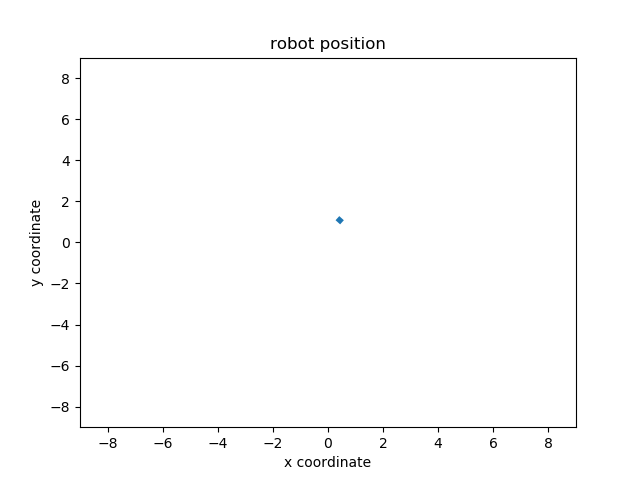

Output(layout=Layout(border='1px solid black'))

<IPython.core.display.Javascript object>


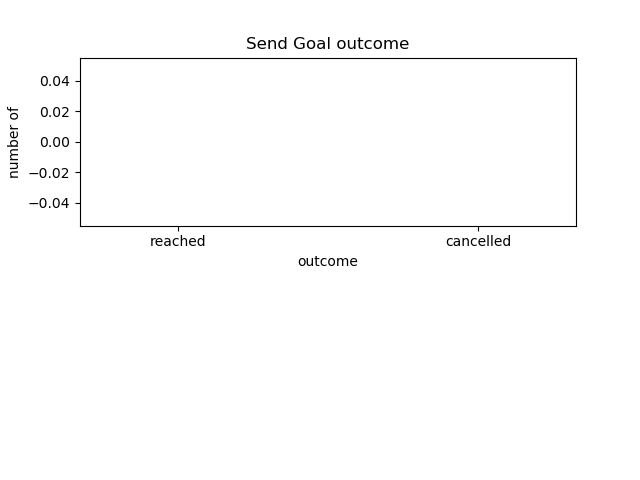

In [9]:
#User Interface (show buttons and plot) only dispaly
vis=Visualizer()

#vis=Visualizer()
sub_odom = rospy.Subscriber('/odom', Odometry, vis.clbk_odom)
ani = FuncAnimation(vis.fig, vis.update_plt, init_func = vis.plot_init)
box= widgets.VBox([widgets.Label('Coordinates to reach'),widgets.HBox([x_val, y_val]), widgets.HBox([send, canc])])
box2= widgets.HBox([widgets.Label('distance from closest obstacles:'),dist])
display(box, info, box2)
fig2 = plt.figure()
ax2 = fig2.add_subplot(2,1,1)
ax2.set_title("Send Goal outcome")
ax2.set_xlabel("outcome")
ax2.set_ylabel("number of")
n_goal()